In [8]:
"""
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, measure
import cv2 as cv
import skimage as ski
import time
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import squidpy as sq
from numpy.random import default_rng
import scanpy as sc
import squidpy as sq
from anndata import AnnData
from statistics import mean
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
import seaborn as sns
from pycirclize import Circos
from pycirclize.parser import Matrix
""";

In [6]:
img_names = ['R1B1ROI1', 'R1B1ROI2', 'R1C1ROI1', 'R1C1ROI2', 'R1D1ROI1', 'R1D1ROI2']

['R1B1ROI1', 'R1B1ROI2', 'R1C1ROI1', 'R1C1ROI2', 'R1D1ROI1', 'R1D1ROI2']

In [14]:
# Load all masks from folder
masks = {}
maskdir = '../02_Segmentation/FinalNucleiCytoSeg/'
for i in img_names:
    filename = i + "_NucleiCytoSegmentationV2.tif"
    maskpath = os.path.join(maskdir, filename)
    mask = io.imread(maskpath)
    masks[i] = mask

In [60]:
# Load in intensity data frames, save dfs, centroids, cell types
intensitydir = "../00_Data/IntensitiesCelltypes/"

intensitydfs = {}
coords = {}
celltypes = {}
areas = {}

for i in img_names:
    filename = i + "_intensitiesdf.csv"
    filepath = os.path.join(intensitydir, filename)
    df = pd.read_csv(filepath)
    
    X_coords = df["X_coord"]
    Y_coords = df["Y_coord"]
    centroidsdf = df[["X_coord", "Y_coord"]]
    coords[i] = centroidsdf

    celltype = df["InferredCellType"]
    celltypes[i] = celltype
    
    area = df["area"]
    areas[i] = area
    
    df = df.iloc[:, 1:-4] # drop first column, is just the cell index, and area, inf.c.t. and centroids
    intensitydfs[i] = df
    

In [273]:
markers = list(intensitydfs["R1B1ROI1"].columns)
print("You are working with the biomarkers {}.".format(markers))
print()

# Reminder of all possible cell types:
print("All cell types:", np.unique(celltypes["R1B1ROI1"]))

You are working with the biomarkers ['actin', 'cd3', 'cd4', 'cd45', 'cd45ro', 'collageni', 'cytokeratin', 'fibulin2', 'lyve1', 'podoplanin', 'cd38', 'cd138'].

All cell types: ['B-cells Plasma' 'Epithelial cells' 'Extracellular matrix'
 'Lymphatic vessel' 'Mixed' 'Myocytes' 'Other' 'T-cells CD4+ (helper)'
 'T-cells Memory' 'T-cells Mixed' 'T-cells Naive']


In [53]:
intensitydfs["R1B1ROI1"]

,actin,cd3,cd4,cd45,cd45ro,collageni,cytokeratin,fibulin2,lyve1,podoplanin,cd38,cd138
0,2267,7279,680,651,4858,1265,5457,6178,1917,3903,618,9684
1,2550,7433,3287,517,15970,2415,5312,6493,1920,538,816,9158
2,1913,8277,5341,1362,9727,1145,6841,4474,2163,5597,1953,9848
3,2525,7557,1108,298,5619,1564,7415,6858,2010,15072,717,10962
4,4271,7910,915,338,4610,33,7120,3326,1993,3715,548,11231
...,...,...,...,...,...,...,...,...,...,...,...,...
11729,2365,6330,1051,346,4296,97,4328,1991,1754,2264,629,10322
11730,2159,5598,757,261,7918,290,5407,3446,1401,1199,532,9288
11731,1619,5582,673,552,9131,564,6197,1459,1414,2871,595,9174
11732,2022,6136,838,3116,3484,594,5803,1454,1720,7635,619,9046


In [20]:
# Filtering
# For this instance, I want to remove "Other" and "Mixed" from this
indices_to_keep = (celltypes_array != "Other") & (celltypes_array != "Mixed")

filtered_centroids = centroids[indices_to_keep]
filtered_celltypes = celltypes_array[indices_to_keep]

In [186]:
# Distance Matrix function

# Function for computing distances between two cell types WITH CENTROIDS
def celltypes_distance_matrix_func(ct1, ct2, celltypes_array, centroids, pool_tcells=False, include_mixed=True, include_other=True):

    cellt = celltypes_array
    centr = centroids
    
    if include_mixed == False:
        indices_to_keep =(cellt != "Mixed")
        centr = centr[indices_to_keep]
        cellt = cellt[indices_to_keep]
        
    if include_other == False:
        indices_to_keep =(cellt != "Other")
        centr = centr[indices_to_keep]
        cellt = cellt[indices_to_keep]
        
    if pool_tcells == True: # Make all T-cell variants into the same
        cellt = np.where(cellt == "T-cells Mixed", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells Naive", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells CD4+ (helper)", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells Memory", "T-cells", cellt)
        #print(cellt[:10])
        
    if len(ct2) == 1:
        # Getting cell indexes from cell types from celltypes_array
        ct1cells = np.where(cellt == ct1)[0]
        ct2cells = np.where(cellt == ct2[0])[0]

        # Making centroids arrays for the selected cells
        ct1coords = centr[ct1cells]
        ct2coords = centr[ct2cells]

        # Calculate distance matrix
        dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
        print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct2[0], dist_mat.shape[0], dist_mat.shape[1]))
    
        return(dist_mat)

    else:
        multiple_dist_mat = {}
        
        for ct in ct2:
            # Getting cell indexes from cell types from celltypes_array
            ct1cells = np.where(cellt == ct1)[0]
            ct2cells = np.where(cellt == ct)[0]

            # Making centroids arrays for the selected cells
            ct1coords = centr[ct1cells]
            ct2coords = centr[ct2cells]

            # Calculate distance matrix
            dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
            print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct, dist_mat.shape[0], dist_mat.shape[1]))
            #multiple_dist_mat[ct] = dist_mat.flatten()
            multiple_dist_mat[ct] = dist_mat
        
        return(multiple_dist_mat)





In [233]:
# Make distance matrices for pooled t cells
dist_mat_pooled_t = {}
ct1 = "T-cells"
ct2 = ["Epithelial cells", "Extracellular matrix", "Lymphatic vessel", "Myocytes"]
pool_tcells = True

for i in img_names:
    celltypes_array = celltypes[i].to_numpy()
    centroids = coords[i].to_numpy()
    dist_mat = celltypes_distance_matrix_func(ct1, 
                                              ct2, 
                                              celltypes_array, 
                                              centroids, 
                                              pool_tcells=pool_tcells)
    dist_mat_pooled_t[i] = dist_mat
    print()



In the distance matrix for the cell types T-cells and Epithelial cells, there are 842 rows and 1974 columns.
In the distance matrix for the cell types T-cells and Extracellular matrix, there are 842 rows and 1319 columns.
In the distance matrix for the cell types T-cells and Lymphatic vessel, there are 842 rows and 209 columns.
In the distance matrix for the cell types T-cells and Myocytes, there are 842 rows and 467 columns.

In the distance matrix for the cell types T-cells and Epithelial cells, there are 860 rows and 235 columns.
In the distance matrix for the cell types T-cells and Extracellular matrix, there are 860 rows and 127 columns.
In the distance matrix for the cell types T-cells and Lymphatic vessel, there are 860 rows and 193 columns.
In the distance matrix for the cell types T-cells and Myocytes, there are 860 rows and 122 columns.

In the distance matrix for the cell types T-cells and Epithelial cells, there are 714 rows and 1255 columns.
In the distance matrix for the 

In [264]:
def plot_violin(data_dict, name, ct1, ct2, show=False):
    
    if len(ct2) == 1:
        print("short")
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create the violin plot
        parts = ax.violinplot(data_dict.flatten(), showmeans=True, showmedians=False)

        # Customize the plot (optional)
        ax.set_title("Violin plot of {} distances to {} for {}".format(ct1, ct2[0], name))
        ax.set_xlabel(ct2[0])
        ax.set_ylabel("Distances")

        if show:
            print(show)
            # Show the plot
            plt.tight_layout()
            plt.show()
        else:
            plt.close(fig)
        
    else:
        keys = list(data_dict.keys())
        data = [data_dict[key].flatten() for key in keys]

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create the violin plot
        parts = ax.violinplot(data, showmeans=True, showmedians=False)

        # Set the x-ticks and x-tick labels
        ax.set_xticks(np.arange(1, len(keys) + 1))
        ax.set_xticklabels(keys)

        # Compute and plot the means manually (optional customization)
        means = [np.mean(d) for d in data]
        ax.scatter(np.arange(1, len(keys) + 1), means, color='red', marker='o', s=50, zorder=3, label='Mean')

        # Annotate the means with their values
        for j, mean in enumerate(means):
            ax.text(j + 1, mean, f'{mean:.2f}', ha='center', va='bottom', fontsize=10, color='red')


        # Customize the plot (optional)
        title = "Violin plot of T-cell distances to structural markers for " + name
        ax.set_title(title)
        ax.set_xlabel('Inferred Cell Types')
        ax.set_ylabel('Distances')

        if show:
            print(show)
            # Show the plot
            plt.tight_layout()
            plt.show()
        else:
            plt.close(fig)
    
    return fig
    

In [270]:
# Create separate violin plots for all images
figures_pooled_t = {}
for i in img_names:
    fig = plot_violin(dist_mat_pooled_t[i], i, ct1, ct2, show=False)
    figures_pooled_t[i] = fig


In [255]:
# Make pooled dist mat for all images
dist_mat_pooled_t_ALLIMG = {}

for ct in ct2: # Loop through cell types
    for i in dist_mat_pooled_t: # Loop through images
        img = dist_mat_pooled_t[i]
        flat_array = img[ct].flatten()
        if ct in dist_mat_pooled_t_ALLIMG:
            dist_mat_pooled_t_ALLIMG[ct] = np.concatenate((dist_mat_pooled_t_ALLIMG[ct], flat_array))
        else:
            dist_mat_pooled_t_ALLIMG[ct] = flat_array



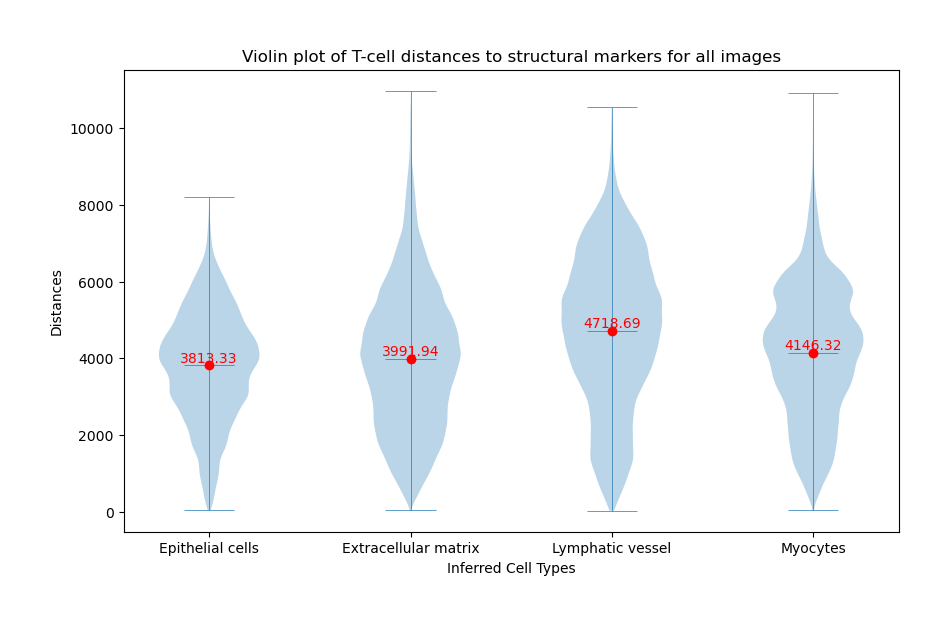

In [269]:
all_img_fig = plot_violin(dist_mat_pooled_t[i], "all images", ct1, ct2, show=False)
plt.figure(all_img_fig)
plt.show()

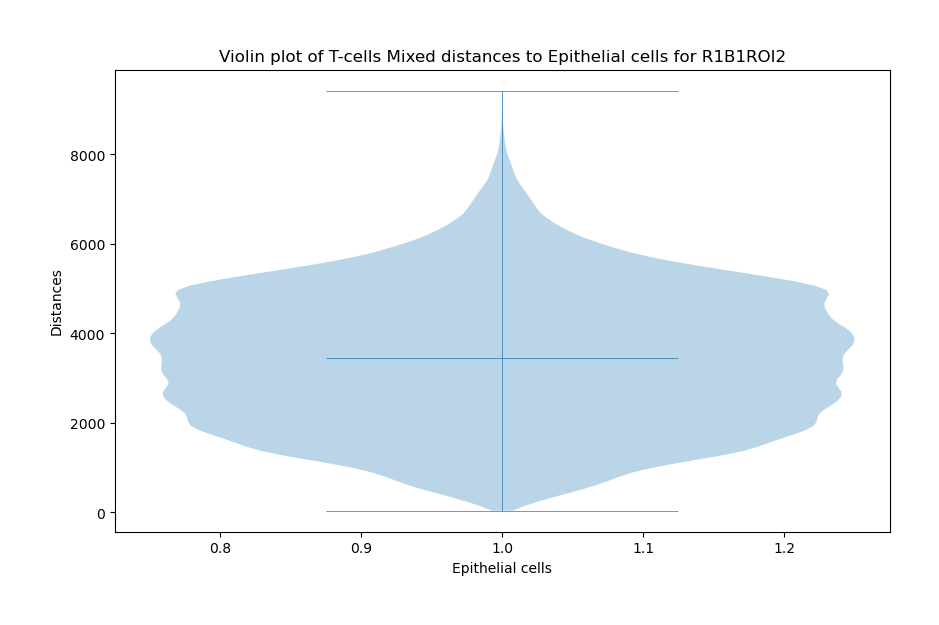

In [223]:
# Save figures:
#for key, fig in figures_dict.items():
    #fig.savefig(f'violin_plot_{key}.png')
    
# Plot just one:
plt.figure(figures_pooled_t["R1B1ROI2"])
plt.show()

### Chord diagram

In [315]:
# Create from-to-table like in the example above

# How big should the radius of cells be? If all cells, put None
radius = 1

cellTypes = np.unique(celltypes_array)

## Add numbers of cells to data frame
# Create t cells df to loop through
tcellsindices = (celltypes_array == "T-cells") | (celltypes_array == "T-cells Mixed") | (celltypes_array == "T-cells Naive") | (celltypes_array == "T-cells CD4+ (helper)")
tcellscentroids = centroids[tcellsindices]
tcellscelltypes = celltypes_array[tcellsindices]
# Create all other cell types dfs
nottcellscentroids = centroids[~tcellsindices]
nottcellscelltypes = celltypes_array[~tcellsindices]

def create_fromtotable(fromcentroids, tocentroids, radius, cellTypes, fromcelltypes, tocelltypes):
    
    # Initialise data frame with combinations of cell types as columns
    combi = []
    for i in cellTypes:
        for j in cellTypes:
            if i != j:
                combi.append([i, j, 0])
    fromto_df = pd.DataFrame(combi, columns=["From", "To", "Amount"])

    # Loop through and calculate distances
    for idx in range(len(fromcentroids)):
        # Calculate distance matrix from this cell idx to all other cells
        cell = fromcentroids[idx] # Cell coordinates
        distances = np.linalg.norm(tocentroids - cell, axis=1) # Np array with all distances for "cell"

        if radius != None:
            distance_idxs = distances.argsort()[:radius] # indexes of closest ones within radius
            distances = distances[distance_idxs] # centroids of closest ones within radius
            selection_celltypes = tocelltypes[distance_idxs]

       
        # Find lowest average distance celltype for this specific cell
        averages_distances = [] # Initialise empty dict for averages
        for ct in cellTypes:
            #print(len(distances), len(selection_celltypes))
            ctdistances = distances[(selection_celltypes == ct)] # for T cells celltype, the ctdistances will be empty
            if len(ctdistances) != 0:
                averages_distances.append(mean(ctdistances))
            else:
                averages_distances.append(-1)

        # Add indication about neareset (lowest dist) celltype for this cell to fromto_df
        closest = averages_distances.index(min([i for i in averages_distances if i >= 0]))
        fromtype = fromcelltypes[idx]
        totype = cellTypes[closest]
        #print(fromtype, totype)
        fromto_df.loc[(fromto_df["From"] == fromtype) & (fromto_df["To"] == totype), "Amount"] += 1
        
    return(fromto_df)
        
fromto_df = create_fromtotable(tcellscentroids, nottcellscentroids, radius, cellTypes, tcellscelltypes, nottcellscelltypes)
   



In [314]:
cellTypes


array(['Epithelial cells', 'Extracellular matrix', 'Lymphatic vessel',
       'Mixed', 'Myocytes', 'Other', 'T-cells CD4+ (helper)',
       'T-cells Mixed', 'T-cells Naive'], dtype=object)

In [316]:
fromto_df

,From,To,Amount
0,Epithelial cells,Extracellular matrix,0
1,Epithelial cells,Lymphatic vessel,0
2,Epithelial cells,Mixed,0
3,Epithelial cells,Myocytes,0
4,Epithelial cells,Other,0
...,...,...,...
67,T-cells Naive,Mixed,4
68,T-cells Naive,Myocytes,1
69,T-cells Naive,Other,4
70,T-cells Naive,T-cells CD4+ (helper),0


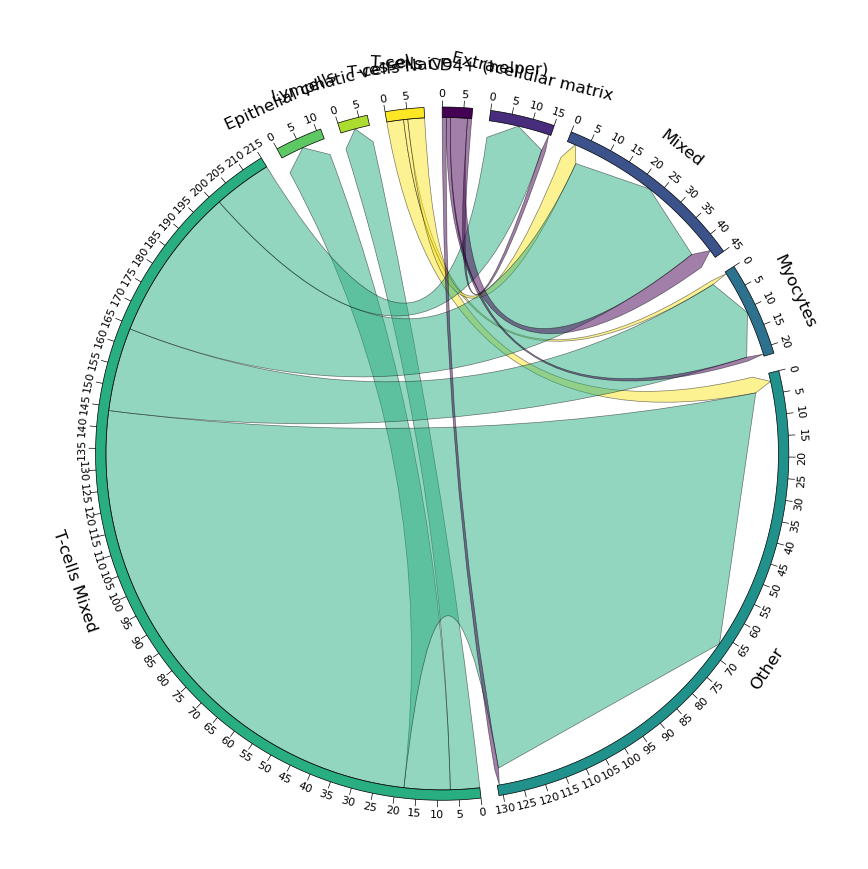

In [319]:
# Make diagram
matrix = Matrix.parse_fromto_table(fromto_df)

mycircos = Circos.initialize_from_matrix(
    matrix,
    space=3,
    cmap="viridis",
    ticks_interval=5,
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)

#print(fromto_df.to_string(index=False))
fig = mycircos.plotfig()


In [153]:
fromto_df

,From,To,Amount
0,Epithelial cells,Extracellular matrix,0
1,Epithelial cells,Lymphatic vessel,0
2,Epithelial cells,Mixed,0
3,Epithelial cells,Myocytes,0
4,Epithelial cells,Other,0
...,...,...,...
85,T-cells mixed,Myocytes,0
86,T-cells mixed,Other,5
87,T-cells mixed,T-cells,0
88,T-cells mixed,T-cells CD4+ (helper),0


In [16]:
print(fromto_df.loc[(fromto_df["From"] == "T-cells Naive")])

             From                     To  Amount
72  T-cells Naive       Epithelial cells       6
73  T-cells Naive   Extracellular matrix       0
74  T-cells Naive       Lymphatic vessel       0
75  T-cells Naive                  Mixed       0
76  T-cells Naive               Myocytes       0
77  T-cells Naive                  Other       4
78  T-cells Naive                T-cells       0
79  T-cells Naive  T-cells CD4+ (helper)       0
80  T-cells Naive          T-cells mixed       0


In [1]:
import plotly.graph_objects as go

# Making df for sankey diagram
sankeydf = fromto_df.copy()
type_index_map = {cell_type: index for index, cell_type in enumerate(cellTypes)}
sankeydf["From"] = sankeydf["From"].replace(type_index_map)
sankeydf["To"] = sankeydf["To"].replace(type_index_map)
#sankeydf["FromLabel"] = fromto_df["From"]
#sankeydf["ToLabel"] = fromto_df["To"]
cols = ['grey',
        'grey',
        'grey',
        'grey',
        'grey',
        'grey',
        'rgba(148, 103, 189, 0.8)',
        'rgba(44, 160, 44, 0.8)',
        'rgba(31, 119, 180, 0.8)',
        'rgba(23, 190, 207, 0.8)'] 
col_index_map = {index: col for index, col in enumerate(cols)}
col_index_map_opaque = {k: v.replace('0.8', '0.4') for k, v in col_index_map.items()}
sankeydf["Colours"] = sankeydf["From"].replace(col_index_map_opaque)


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = cellTypes,
      color = cols
    ),
    link = dict(
      source = sankeydf["From"], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = sankeydf["To"],
      value = sankeydf["Amount"],
      color = sankeydf["Colours"]
  ))])

fig.update_layout(title_text="Distance Sankey diagram", font_size=10)  
fig.show()

NameError: name 'fromto_df' is not defined

In [300]:
np.unique(celltypes_array)

array(['Epithelial cells', 'Extracellular matrix', 'Lymphatic vessel',
       'Mixed', 'Myocytes', 'Other', 'T-cells', 'T-cells CD4+ (helper)',
       'T-cells Naive', 'T-cells mixed'], dtype=object)